In [8]:
import numpy as np
from sklearn.datasets import make_classification
import xgboost as xgb
import sklearn
import matplotlib.pyplot as plt
import shap
import seaborn as sns
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
import collections
import pandas as pd

shap.initjs()

We use scikit-learn to create a synthatic dataset for binary classification. We create a dataset with 10000 samples and 10 features. 5 of the features provide information about the target variable, while the other features are not correlated with the target variable.

In [30]:
ds = make_classification(n_samples=10000, 
                         n_features=10, 
                         n_informative=5, 
                         n_redundant=0, 
                         n_repeated=0, 
                         n_classes=2, 
                         flip_y=0.05,  
                         shuffle=True, 
                         random_state=1)


Let's do boxplots of each feature with the target variable to see which variables seems to influence the target.

C:\Program Files\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


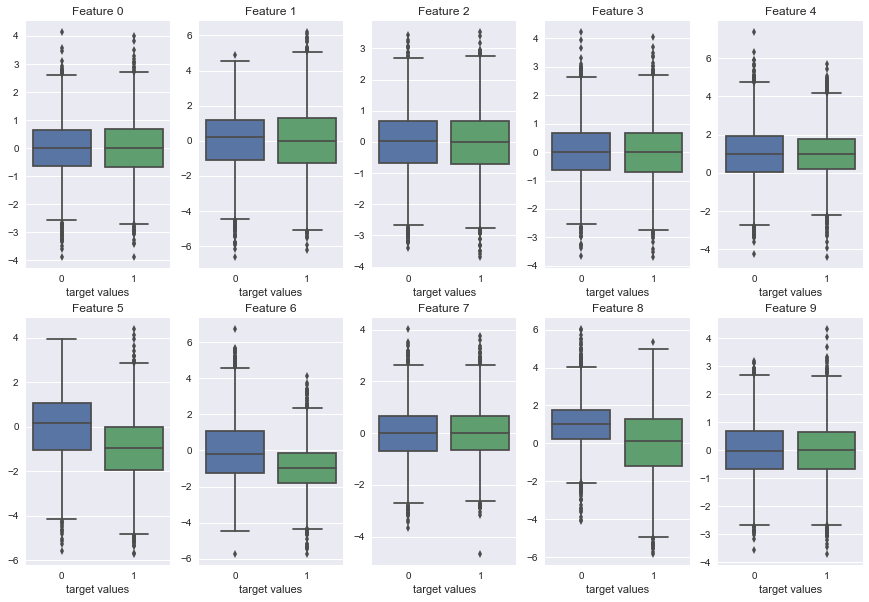

In [42]:
fig, axarr = plt.subplots(2, 5, figsize=(15, 10))

for i in range(10):
    row = int(i / 5)
    column = int(i % 5)
    sns.boxplot(x=ds[1], y=ds[0][:,i], ax=axarr[row][column])
    axarr[row][column].set_title('Feature ' + str(i))
    axarr[row][column].set_xlabel('target values')


Seems like Feature 1, Feature 4, Feature 5, Feature 6, and Feature 8 can have influence with the target variable

In [43]:
# Split the in training and validation sets
X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(ds[0], ds[1], test_size=0.2, random_state=1)
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(8000, 10)
(2000, 10)
(8000,)
(2000,)


We train two models: XGBoost and Naive Bayes. We want to focus on how SHAP values can explain the predictions, so we do not optimize the hyperparameters to optimize an evaluation metric.

In [44]:
# Train XGBoost
d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_valid, label=y_valid)
model = xgb.train({"learning_rate": 0.01}, d_train, 100)

# Train Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB(priors=None)

In [45]:
# Compute the AUC just to see how they do
auc_xgboost_train = sklearn.metrics.roc_auc_score(y_train, model.predict(d_train))
auc_xgboost_valid = sklearn.metrics.roc_auc_score(y_valid, model.predict(d_valid))
auc_nb_train = sklearn.metrics.roc_auc_score(y_train, nb.predict_proba(X_train)[:,1])
auc_nb_valid = sklearn.metrics.roc_auc_score(y_valid, nb.predict_proba(X_valid)[:,1])
                              
print('AUC Train: ' + str(auc_xgboost_train) + ' (XGB) - ' + str(auc_nb_train) + ' NB')
print('AUC Valid: ' + str(auc_xgboost_valid) + ' (XGB) - ' + str(auc_nb_valid) + ' NB')

AUC Train: 0.9678637436757167 (XGB) - 0.846132403362351 NB
AUC Valid: 0.9415030943942799 (XGB) - 0.850935920481019 NB


Let's show the importance of the features returned by the XGBoost package. We should see 5 features have high importance, and 5 features have very low importance.

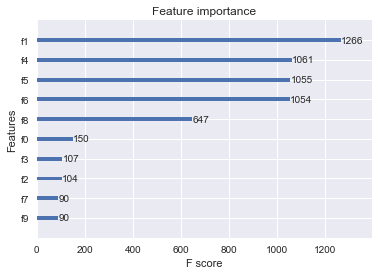

In [46]:
from xgboost import plot_importance
plot_importance(model)
pyplot.show()

Now, let's see the SHAP values obtained to explain the XGBoost model. To obtain them, we use the TreeExplainer in the SHAP library. The TreeExplainer implementation is based on "Consistent Individualized Feature Attribution for Tree Ensembles" paper

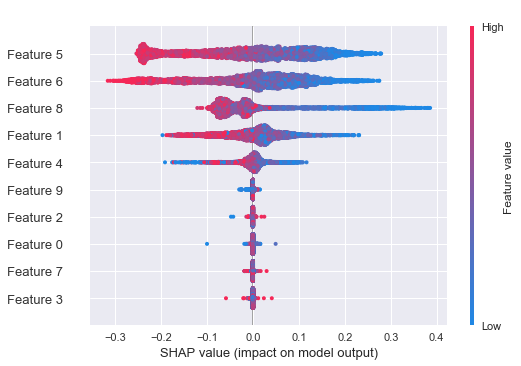

In [47]:
shap_values_xgboost = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values_xgboost, X_train)

This plots shows all the SHAP values for the training set. As we see, Features 5,6,8,1 and 4 have higher SHAP values. Therefore we see that they effectively can represent the importance of the features on the model.

Now let's look at the Naive Bayes model. Here we use the KernelExplainer, which is explained in the paper "A unified approach to explain the output of any machine learning model"

In [48]:
f_nb = lambda x: nb.predict_proba(x)[:,1]
med = np.median(X_train, axis=0).reshape((1,X_train.shape[1]))
explainer_nb = shap.KernelExplainer(f_nb, med)
shap_values_nb = explainer_nb.shap_values(X_train) 

100%|█████████████████████████████████████████████████████████████████████████████████| 8000/8000 [07:50<00:00, 17.01it/s]


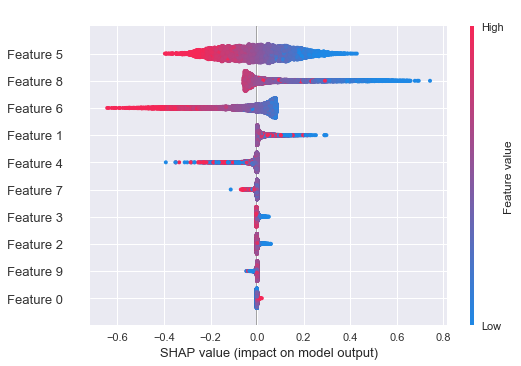

In [49]:
shap.summary_plot(shap_values_nb, X_train)

We notice here that it takes a lot of time to compute the SHAP values for all the predictions. The TreeExplainer used before is implemented in C++, while the KernelExplainer is only in Python. Besides, the computational complexity of the TreeExplainer is lower than the KernelExplainer. The reason to use KernelExplainer is that it works for any classifier, while the TreeExplainer is only for tree ensemble methods.

Independently of the computational time, it seems that KernelExplainer effectively obtains SHAP values that are able to explain the predictions of the model.

We can also look at individual predictions. In the next sample, we see the explanation of an individual prediction for the XGBoost model. What we see is that the most important feature is F5, which makes the output prediction to be quite lower than the base value. Features 8 and 4 also make the ouptut prediction to be lower, while feautres 6 and 1 make the output prediction to be higher. We see that the other features don't receive importance as their SHAP values are very low.

In [50]:
# Individual prediction for xgboost model
idx = 0
shap.force_plot(shap_values_xgboost[idx,:], X_train[idx,:], 
                feature_names=['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9'])

We see that we get similar explanations using the Naive Bayes model

In [52]:
# Individual predictions for Naive Bayes model
idx = 0
shap.force_plot(shap_values_nb[idx,:], X_train[idx,:], 
                feature_names=['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9'])

Now, let's create another dataset with 5 features, 3 of them informative. 

In [53]:
ds2 = make_classification(n_samples=10000, 
                         n_features=5, 
                         n_informative=3, 
                         n_redundant=0, 
                         n_repeated=0, 
                         n_classes=2, 
                         flip_y=0.05, 
                         random_state=1)

Looking the boxplot of feature 1, seems that feature 1 is not an informative feature:

C:\Program Files\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


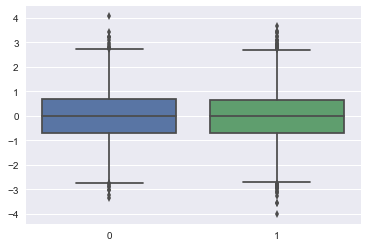

In [64]:
sns.boxplot(x=ds2[1], y=ds2[0][:,1])

Let's modify the target variable according to the value of this feature, so then this feature will be informative:

In [65]:
# for feature 1 we will assign it to certain pattern which will provide a lot of info:
# when value is between [0.5, inf] we will change the class for 0 on 75% of the cases
# when value is between [-inf, -0.5] we will change the class for 1 on 75% of the cases
# when value is between [-0.5, 0.5] we will keep the class
print('Before modification: ')
print(collections.Counter(ds2[1][ds2[0][:,1] > 0.5]))
print(collections.Counter(ds2[1][np.multiply(ds2[0][:,1] <= 0.5 , ds2[0][:,1] > -0.5)]))
print(collections.Counter(ds2[1][ds2[0][:,1] < -0.5]))

for i in range(len(ds2[0])):
    if ds2[0][i,1] > 0.5:
        if np.random.uniform() < 0.75:
            ds2[1][i] = 0
    elif ds2[0][i,1] < -0.5:
        if np.random.uniform() < 0.75:
            ds2[1][i] = 1


Before modification: 
Counter({0: 1538, 1: 1514})
Counter({1: 1882, 0: 1873})
Counter({1: 1605, 0: 1588})
After modification


In [66]:
print('After modification')
print(collections.Counter(ds2[1][ds2[0][:,1] > 0.5]))
print(collections.Counter(ds2[1][np.multiply(ds2[0][:,1] <= 0.5 , ds2[0][:,1] > -0.5)]))
print(collections.Counter(ds2[1][ds2[0][:,1] < -0.5]))

After modification
Counter({0: 2666, 1: 386})
Counter({1: 1882, 0: 1873})
Counter({1: 2801, 0: 392})


Let's train the models:

In [67]:
X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(ds2[0], ds2[1], test_size=0.2, random_state=1)
d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_valid, label=y_valid)

model = xgb.train({"learning_rate": 0.01}, d_train, 100)
nb = GaussianNB()
nb.fit(X_train, y_train)

print('AUC Train: ' + str(auc_xgboost_train) + ' (XGB) - ' + str(auc_nb_train) + ' NB')
print('AUC Valid: ' + str(auc_xgboost_valid) + ' (XGB) - ' + str(auc_nb_valid) + ' NB')

AUC Train: 0.9678637436757167 (XGB) - 0.846132403362351 NB
AUC Valid: 0.9415030943942799 (XGB) - 0.850935920481019 NB


And now look at the SHAP values

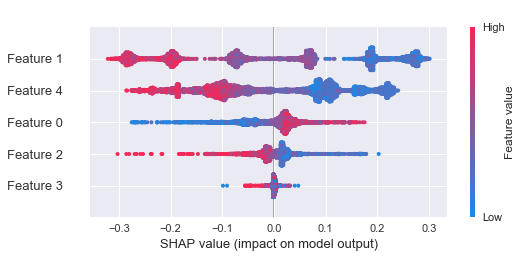

In [69]:
shap_values_xgboost = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values_xgboost, X_train)

In [70]:
f_nb = lambda x: nb.predict_proba(x)[:,1]
med = np.median(X_train, axis=0).reshape((1,X_train.shape[1]))
explainer_nb = shap.KernelExplainer(f_nb, med)
shap_values_nb = explainer_nb.shap_values(X_train) 

100%|████████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:30<00:00, 266.57it/s]


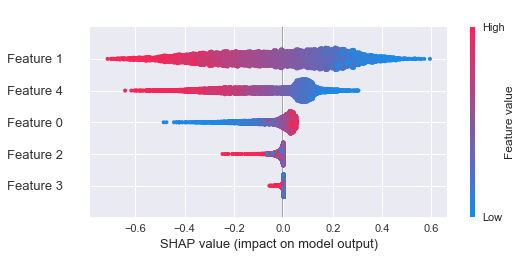

In [71]:
# summarize the effects of all the features
shap.summary_plot(shap_values_nb, X_train)

Seems good. Now, let's look at the samples where we changed the target variable in base of feature 1. They should get higher SHAP values for feature 1 than the samples where we did not change the target variable.

In [102]:
print('XGBoost:')
modified_shap_values_f1 = np.concatenate((shap_values_xgboost[X_train[:,1] < -0.5][:,1], 
                                       shap_values_xgboost[X_train[:,1] > 0.5][:,1]))
not_modified_shap_values_f1 = shap_values_xgboost[(X_train[:,1] > -0.5) & (X_train[:,1] < 0.5)][:,1]
print(np.mean(np.abs(modified_shap_values_f1)))
print(np.mean(np.abs(not_modified_shap_values_f1)))

print('Naive Bayes:')
modified_shap_values_f1 = np.concatenate((shap_values_nb[X_train[:,1] < -0.5][:,1], 
                                       shap_values_nb[X_train[:,1] > 0.5][:,1]))
not_modified_shap_values_f1 = shap_values_nb[(X_train[:,1] > -0.5) & (X_train[:,1] < 0.5)][:,1]
print(np.mean(np.abs(modified_shap_values_f1)))
print(np.mean(np.abs(not_modified_shap_values_f1)))

XGBoost:
0.23258975
0.065313935
Naive Bayes:
0.2939004001042462
0.07711848189413374


Indeed, the samples for which we change the target variable, and therefore feature 1 is important, seems to get higher SHAP values.

Let's see a couple of examples to finalize

In [105]:
# Individual where f1 is important
idx = 7
print(X_train[idx,1])
shap.force_plot(shap_values_xgboost[idx,:], X_train[idx,:], 
                feature_names=['f0', 'f1', 'f2', 'f3', 'f4'])

-1.071841866560117


In [117]:
# Individual where f1 is not important
idx = 1
print(X_train[idx,1])
shap.force_plot(shap_values_xgboost[idx,:], X_train[idx,:], 
                feature_names=['f0', 'f1', 'f2', 'f3', 'f4'])

-0.28380977748610003


The first sample gets higher importance for feature 1.

It seems that the method works quite well to explain the predictions of any model.

One concern is about the computational time required to explain the prediction. Let's try a dataset with a lot of features. 100000 samples with 800 features, only 10 informative

In [118]:
ds3 = make_classification(n_samples=100000, 
                         n_features=800, 
                         n_informative=10, 
                         n_redundant=0, 
                         n_repeated=0, 
                         n_classes=2, 
                         n_clusters_per_class=2, 
                         flip_y=0.05, 
                         random_state=1)

In [120]:
X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(ds3[0], ds3[1], test_size=0.2, random_state=1)

d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_valid, label=y_valid)

evallist = [(d_valid, 'valid'), (d_train, 'train')]

# Train xgboost and naive bayes
model = xgb.train({"learning_rate": 0.05}, d_train, 50, evals=evallist, verbose_eval=10)
nb = GaussianNB()
nb.fit(X_train, y_train)

# Performance on valid set
auc_xgboost_train = sklearn.metrics.roc_auc_score(y_train, model.predict(d_train))
auc_xgboost_valid = sklearn.metrics.roc_auc_score(y_valid, model.predict(d_valid))
auc_nb_train = sklearn.metrics.roc_auc_score(y_train, nb.predict_proba(X_train)[:,1])
auc_nb_valid = sklearn.metrics.roc_auc_score(y_valid, nb.predict_proba(X_valid)[:,1])
                              
print('AUC Train: ' + str(auc_xgboost_train) + ' (XGB) - ' + str(auc_nb_train) + ' NB')
print('AUC Valid: ' + str(auc_xgboost_valid) + ' (XGB) - ' + str(auc_nb_valid) + ' NB')

[0]	valid-rmse:0.485747	train-rmse:0.485568
[10]	valid-rmse:0.384345	train-rmse:0.382242
[20]	valid-rmse:0.329688	train-rmse:0.32592
[30]	valid-rmse:0.298861	train-rmse:0.293695
[40]	valid-rmse:0.281253	train-rmse:0.274816
[49]	valid-rmse:0.272536	train-rmse:0.265106
AUC Train: 0.9666334650799858 (XGB) - 0.8818115333496573 NB
AUC Valid: 0.961847616305332 (XGB) - 0.8730145977771528 NB


In [121]:
# Compute SHAP values for xgboost
shap_values_xgboost = shap.TreeExplainer(model).shap_values(X_train)

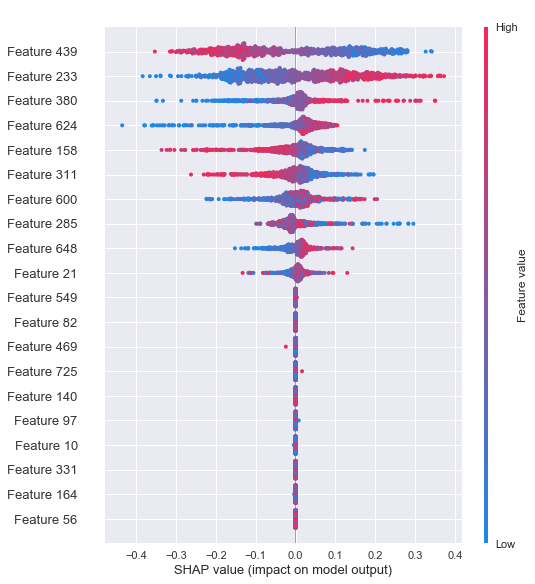

In [122]:
# summarize the effects of all the features - xgboost
shap.summary_plot(shap_values_xgboost[0:1000], X_train[0:1000], max_display=20)

In [123]:
# Compute SHAP values for Naive Bayes
f_nb = lambda x: nb.predict_proba(x)[:,1]
med = np.median(X_train, axis=0).reshape((1,X_train.shape[1]))
explainer_nb = shap.KernelExplainer(f_nb, med)
shap_values_nb = explainer_nb.shap_values(X_train[0:200])

100%|███████████████████████████████████████████████████████████████████████████████████| 200/200 [34:57<00:00, 10.49s/it]


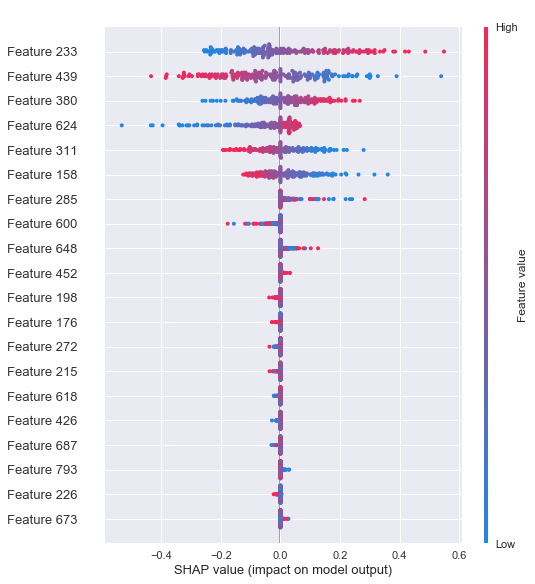

In [124]:
# summarize the effects of all the features - Naive Bayes
shap.summary_plot(shap_values_nb, X_train[0:200], max_display=20)

We see that the SHAP values make sense, but it is also very slow to compute, specially the Kernel Explainer which can take until 10 seconds per iteration.

When computing the SHAP values, the Kernel Explainer has a parameter nsamples that we sample around the data point to be explained. I higher value means that we get better approximations to the SHAP values. However, higher values also means more computation time, so we can try to set it lower, and see if we can get good approximation of SHAP values with low computational time:

In [131]:
# Compute SHAP values for Naive Bayes - 50 samples
f_nb = lambda x: nb.predict_proba(x)[:,1]
med = np.median(X_train, axis=0).reshape((1,X_train.shape[1]))
explainer_nb = shap.KernelExplainer(f_nb, med)
shap_values_nb = explainer_nb.shap_values(X_train[0:275], nsamples=50)

  0%|▎                                                                                    | 1/275 [00:00<01:04,  4.24it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.648e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.648e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dro

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.560e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.560e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.539e-03, with an active set of 9 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=2.210e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=2.197e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=2.181e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.422e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=1.404e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=1.404e-03, with an active set of 18 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=1.278e-03, with an active set of 19 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=1.274e-03, with an active set of 19 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=1.272e-03, with an active set of 19 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=9.852e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=9.852e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=9.852e-04, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=8.973e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=8.967e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=8.962e-04, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=7.620e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=7.605e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 7.068e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=7.578e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=8.766e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=8.750e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=8.739e-03, with an active set of 7 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=8.450e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=8.449e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=7.418e-03, with an active set of 8 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=7.063e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 5.771e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=7.063e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=7.045e-03, with an active set of 10 regressors, and the smallest choles

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=6.357e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=6.330e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=6.311e-03, with an active set of 20 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=6.068e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=6.067e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=6.066e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=6.050e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=6.049e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 5.771e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=6.048e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=6.038e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=6.037e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=6.037e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=6.025e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=6.023e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=6.023e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=6.010e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 5.373e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=6.010e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=6.010e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.999e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.999e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 4.081e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.999e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.992e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.992e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 4.593e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.992e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.985e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.985e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.985e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.979e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.979e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 4.829e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.979e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.972e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.972e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.972e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.966e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.966e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.965e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.959e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.959e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.959e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.953e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.953e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.953e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.946e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 4.344e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.946e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 5.576e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.946e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.934e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.933e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.933e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.920e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.918e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.918e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=2.214e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=2.214e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=2.214e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=2.197e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=2.195e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=2.194e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=2.178e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 6.495e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=2.178e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=2.167e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.045e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.045e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.045e-03, with an active set of 16 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.040e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 5.373e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.039e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.038e-03, with an active set of 16 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.032e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.029e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.029e-03, with an active set of 16 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.010e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 3.495e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.008e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=9.694e-04, with an active set of 17 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=9.504e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=9.500e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=9.499e-04, with an active set of 18 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=7.184e-04, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=7.109e-04, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.705e-04, with an active set of 24 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=6.661e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=6.661e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=6.660e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=5.001e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=4.998e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=4.995e-03, with an active set of 16 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=4.353e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=4.329e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=4.307e-03, with an active set of 17 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=6.173e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=3.678e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=3.374e-03, with an active set of 10 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=2.343e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=2.333e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=2.314e-03, with an active set of 16 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.881e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.875e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.868e-03, with an active set of 7 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.541e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.538e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.536e-03, with an active set of 14 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.089e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.470e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.470e-03, with an active set of 6 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=7.627e-04, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=7.559e-04, with an active set of 12 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=7.434e-04, with an active set of 13 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.791e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 3.495e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.788e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.779e-03, with an active set of 8 regressors, and the smallest cholesky

  5%|███▉                                                                                | 13/275 [00:07<02:32,  1.72it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=7.836e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.918e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dro

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=5.162e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=5.076e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=4.863e-03, with an active set of 10 regressors, and the smallest chol

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=3.531e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 9.657e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=3.531e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=3.531e-03, with an active set of 13 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=4.203e-03, previous alpha=4.050e-03, with an active set of 8 regressors.
  ConvergenceWarning)
  7%|█████▍                                                                              | 18/275 [00:08<02:08,  2.01it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=4.123e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 i

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.566e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.552e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.533e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=7.743e-04, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=7.742e-04, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=7.741e-04, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=4.836e-04, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=4.788e-04, with an active set of 17 regressors, and the smallest cholesky pivot element being 4.344e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=4.751e-04, with an active set of 17 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=3.886e-04, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=3.885e-04, with an active set of 19 regressors, and the smallest cholesky pivot element being 6.322e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=3.885e-04, with an active set of 19 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=3.148e-04, with an active set of 21 regressors, and the smallest cholesky pivot element being 3.495e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=3.098e-04, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=3.097e-04, with an active set of 21 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=2.729e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=2.727e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=2.718e-04, with an active set of 22 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=2.458e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=2.434e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=2.414e-04, with an active set of 22 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=2.174e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 6.322e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=2.174e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=2.165e-04, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=1.871e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 6.829e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=1.867e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 7.743e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=1.857e-04, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.491e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.467e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.448e-04, with an active set of 25 regressors, and the smallest ch

  8%|██████▋                                                                             | 22/275 [00:10<02:05,  2.01it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.781e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.781e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dro

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=6.850e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=6.850e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=6.791e-03, with an active set of 6 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.918e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.914e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.905e-03, with an active set of 13 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.749e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.748e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.747e-03, with an active set of 16 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.572e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 4.081e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.566e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.558e-03, with an active set of 18 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 24 iterations, alpha=1.805e-03, previous alpha=1.419e-03, with an active set of 19 regressors.
  ConvergenceWarning)
  9%|███████▋                                                                            | 25/275 [00:12<02:01,  2.06it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.237e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=4.019e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=4.017e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=4.013e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=3.860e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=3.860e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=3.858e-03, with an active set of 11 regressors, and the smallest ch

  9%|███████▉                                                                            | 26/275 [00:12<02:00,  2.06it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=9.592e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=9.592e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dro

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=4.662e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=4.661e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=4.644e-03, with an active set of 7 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=3.876e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=3.818e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=3.817e-03, with an active set of 9 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=4.701e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=4.688e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=4.685e-03, with an active set of 8 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.524e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.511e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=5.253e-03, with an active set of 6 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=2.893e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.849e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=2.731e-03, with an active set of 14 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=2.474e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=2.472e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=2.456e-03, with an active set of 21 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.883e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.881e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.878e-03, with an active set of 22 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.756e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.754e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.747e-03, with an active set of 22 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.669e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.653e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.651e-03, with an active set of 22 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.439e-03, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.434e-03, with an active set of 23 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.429e-03, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.137e-03, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.125e-03, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.111e-03, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=9.474e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=9.394e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=9.342e-04, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=8.690e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 28 iterations, alpha=3.602e-03, previous alpha=8.689e-04, with an active set of 23 regressors.
  ConvergenceWarning)
 11%|████████▊                                                                           | 29/275 [00:14<02:03,  1.99it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.414e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 6.495e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.412e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 8.816e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.412e-02, with an active set of 7 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=2.516e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=2.515e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=2.514e-03, with an active set of 17 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=2.046e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 5.373e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=2.023e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=2.009e-03, with an active set of 21 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.787e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.785e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.776e-03, with an active set of 21 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=9.337e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 11 iterations, alpha=9.404e-03, previous alpha=9.027e-03, with an active set of 6 regressors.
  ConvergenceWarning)
 12%|█████████▊                                                                          | 32/275 [00:15<01:59,  2.04it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.204e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.203e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.201e-03, with an active set of 18 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.069e-03, with an active set of 19 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.067e-03, with an active set of 19 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 24 iterations, alpha=1.234e-03, previous 

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.591e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.574e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 14 iterations, alpha=1.798e-03, previous 

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.029e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.028e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.028e-02, with an active set of 6 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 14 iterations, alpha=1.023e-02, previous alpha=9.047e-03, with an active set of 13 regressors.
  ConvergenceWarning)
 13%|██████████▋                                                                         | 35/275 [00:16<01:54,  2.09it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.326e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.074e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 3.495e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.073e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.073e-02, with an active set of 9 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.043e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.042e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.042e-02, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.033e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 7.743e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.031e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 8.162e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.031e-02, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=4.863e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=4.861e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=4.855e-03, with an active set of 9 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.304e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.302e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.302e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=5.526e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=5.433e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=5.433e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.850e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 22 iterations, alpha=1.865e-03, previous alpha=1.833e-03, with an active set of 17 regressors.
  ConvergenceWarning)
 15%|████████████▏                                                                       | 40/275 [00:18<01:47,  2.18it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=4.687e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=4.673e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=4.434e-03, with an active set of 13 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=3.271e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=3.259e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=3.236e-03, with an active set of 17 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=3.003e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=2.999e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=2.971e-03, with an active set of 17 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=2.536e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=2.514e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=2.505e-03, with an active set of 20 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=2.052e-03, with an active set of 25 regressors, and the smallest cholesky pivot element being 8.093e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=2.047e-03, with an active set of 25 regressors, and the smallest cholesky pivot element being 3.799e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=2.040e-03, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.848e-03, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.840e-03, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.833e-03, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.515e-03, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.501e-03, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.501e-03, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.229e-03, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.227e-03, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.222e-03, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.013e-03, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.004e-03, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=9.946e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=7.113e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=6.848e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=6.814e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=4.376e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=4.360e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=4.358e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.887e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.875e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.840e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.391e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.344e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.383e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.190e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.242e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.180e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.160e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=8.350e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=5.672e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.976e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.785e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.777e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.774e-03, with an active set of 7 regressors, and the smallest cholesky

 16%|█████████████▏                                                                      | 43/275 [00:20<01:49,  2.12it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=4.416e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=2.449e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dr

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.229e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.227e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.226e-02, with an active set of 9 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.219e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.219e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.219e-02, with an active set of 9 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.212e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.212e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.210e-02, with an active set of 9 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.200e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.200e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.200e-02, with an active set of 9 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.134e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.133e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.133e-02, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.124e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.124e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.123e-02, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.111e-02, with an active set of 12 regressors, and the smallest cholesky pivot element being 7.376e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.111e-02, with an active set of 12 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.111e-02, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 23 iterations, alpha=1.214e-02, previous alpha=1.084e-02, with an active set of 20 regressors.
  ConvergenceWarning)
 16%|█████████████▋                                                                      | 45/275 [00:21<01:49,  2.11it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.181e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=5.292e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=5.289e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=5.287e-03, with an active set of 7 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=5.205e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=5.204e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=5.199e-03, with an active set of 7 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=4.408e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=4.408e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=4.406e-03, with an active set of 8 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=5.224e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=5.224e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=5.141e-03, with an active set of 8 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.879e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.874e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.861e-03, with an active set of 4 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=2.796e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=2.795e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=2.776e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.412e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.412e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.410e-03, with an active set of 16 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.366e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.847e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.847e-03, with an active set of 4 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.355e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.355e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.351e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=9.389e-04, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 18 iterations, alpha=9.731e-04, previous alpha=9.366e-04, with an active set of 15 regressors.
  ConvergenceWarning)
 19%|███████████████▌                                                                    | 51/275 [00:23<01:42,  2.18it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.013e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.013e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.011e-02, with an active set of 8 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 18 iterations, alpha=8.191e-03, previous alpha=7.121e-03, with an active set of 15 regressors.
  ConvergenceWarning)
 19%|███████████████▉                                                                    | 52/275 [00:23<01:42,  2.18it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=7.598e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.929e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.870e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.850e-03, with an active set of 9 regressors, and the smallest cholesky

 20%|████████████████▍                                                                   | 54/275 [00:24<01:40,  2.20it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=3.951e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.176e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dro

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.399e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.398e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.393e-02, with an active set of 8 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.258e-02, with an active set of 13 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.253e-02, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.253e-02, with an active set of 14 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.187e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.186e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.185e-02, with an active set of 9 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.169e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.169e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.167e-02, with an active set of 9 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.647e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.077e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 33 iterations, i.e. alpha=9.844e-04, with an active set of 13 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 33 iterations, i.e. alpha=9.041e-04, with an active set of 13 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 33 iterations, i.e. alpha=9.038e-04, with an active set of 13 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 35 iterations, alpha=9.839e-04, previous 

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.127e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.126e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.119e-02, with an active set of 6 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=4.446e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=4.324e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=4.324e-03, with an active set of 7 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=3.038e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=3.038e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=3.037e-03, with an active set of 13 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=3.029e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=3.028e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=3.027e-03, with an active set of 13 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=3.014e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=3.014e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=3.013e-03, with an active set of 13 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.429e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.428e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 8.025e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.423e-02, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.274e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.274e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.274e-02, with an active set of 6 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.630e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=6.463e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=5.261e-03, with an active set of 6 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=3.081e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=3.048e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=3.048e-03, with an active set of 17 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=2.912e-03, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=2.910e-03, with an active set of 19 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=2.890e-03, with an active set of 19 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=2.681e-03, with an active set of 19 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=2.678e-03, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=2.633e-03, with an active set of 19 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=2.442e-03, with an active set of 19 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=2.423e-03, with an active set of 19 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=2.417e-03, with an active set of 19 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.992e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 5.373e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.992e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.953e-03, with an active set of 20 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=9.726e-04, with an active set of 21 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=9.667e-04, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=9.656e-04, with an active set of 21 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=5.794e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=5.753e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=5.726e-04, with an active set of 22 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.772e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.771e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=1.020e-03, with an active set of 12 regressors, and the smallest choles

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=8.450e-04, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=8.445e-04, with an active set of 19 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=8.444e-04, with an active set of 19 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=4.389e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=4.226e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=4.182e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=4.021e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=4.009e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=4.001e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.321e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.300e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.291e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.656e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.654e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.648e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.095e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.966e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.955e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.355e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.284e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.253e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=7.341e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=7.270e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=6.851e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.376e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.331e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.189e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=6.332e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=6.332e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=6.308e-03, with an active set of 8 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.186e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.179e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.171e-02, with an active set of 4 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=6.372e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=5.762e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=5.318e-03, with an active set of 15 regressors, and the smallest chol

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=4.478e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=4.376e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=4.208e-03, with an active set of 21 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=3.443e-03, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=3.428e-03, with an active set of 25 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=3.425e-03, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=3.218e-03, with an active set of 25 regressors, and the smallest cholesky pivot element being 5.576e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=3.211e-03, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=3.211e-03, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=5.347e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=5.347e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=3.298e-03, with an active set of 9 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=2.467e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=2.426e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=2.173e-03, with an active set of 15 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.554e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.537e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.530e-03, with an active set of 16 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.364e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 3.799e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.362e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=1.277e-03, with an active set of 18 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=4.451e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=4.419e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=4.410e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=4.179e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=4.172e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 4.344e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=4.138e-03, with an active set of 15 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=3.642e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=3.640e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=3.639e-03, with an active set of 21 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=3.356e-03, with an active set of 23 regressors, and the smallest cholesky pivot element being 5.268e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=3.351e-03, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=3.344e-03, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.107e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.107e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.106e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.135e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.315e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.315e-03, with an active set of 7 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.264e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.933e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 11 iterations, alpha=2.035e-03, previous al

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=7.730e-04, with an active set of 10 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=7.611e-04, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=7.595e-04, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 41 iterations, i.e. alpha=4.384e-04, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 41 iterations, i.e. alpha=4.384e-04, with an active set of 21 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 41 iterations, i.e. alpha=4.383e-04, with an active set of 21 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 42 iterations, i.e. alpha=4.129e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 42 iterations, i.e. alpha=4.125e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 42 iterations, i.e. alpha=4.115e-04, with an active set of 22 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 43 iterations, i.e. alpha=4.069e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 43 iterations, i.e. alpha=4.068e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 43 iterations, i.e. alpha=4.062e-04, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 43 iterations, i.e. alpha=3.991e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 43 iterations, i.e. alpha=3.989e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 43 iterations, i.e. alpha=3.986e-04, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 43 iterations, i.e. alpha=3.942e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 8.297e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 43 iterations, i.e. alpha=3.941e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 43 iterations, i.e. alpha=3.940e-04, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 43 iterations, i.e. alpha=3.851e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 43 iterations, i.e. alpha=3.850e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 6.322e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 43 iterations, i.e. alpha=3.845e-04, with an active set of 23 regressors, and the smallest ch

 27%|██████████████████████▉                                                             | 75/275 [00:33<01:28,  2.25it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=3.403e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.702e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate.

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.698e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.697e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.697e-03, with an active set of 15 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.693e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 6.144e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.693e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.693e-03, with an active set of 15 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.688e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.688e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.688e-03, with an active set of 15 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.684e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.684e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.683e-03, with an active set of 15 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.676e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.675e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.674e-03, with an active set of 15 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.667e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.666e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.666e-03, with an active set of 15 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.503e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.501e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.500e-04, with an active set of 18 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.487e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.486e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.483e-04, with an active set of 18 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.466e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.464e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.463e-04, with an active set of 18 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.441e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 4.081e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.440e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.440e-04, with an active set of 18 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.422e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.422e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.422e-04, with an active set of 18 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.391e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.387e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.387e-04, with an active set of 18 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.346e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.345e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 6.322e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.344e-04, with an active set of 18 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.224e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 32 iterations, alpha=8.191e-04, previous alpha=7.755e-04, with an active set of 19 regressors.
  ConvergenceWarning)
 28%|███████████████████████▏                                                            | 76/275 [00:34<01:30,  2.20it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=7.110e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=7.028e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=7.025e-03, with an active set of 10 regressors, and the smallest cho

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.238e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.238e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.237e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=3.427e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=3.365e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=3.364e-03, with an active set of 9 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=2.784e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 3.799e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=2.783e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=2.783e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.675e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.675e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.674e-03, with an active set of 14 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=2.603e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=2.601e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=2.596e-03, with an active set of 15 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=2.520e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=2.520e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=2.518e-03, with an active set of 16 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=2.312e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=2.311e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=2.310e-03, with an active set of 20 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=2.210e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=2.208e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=2.191e-03, with an active set of 21 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=2.086e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=2.081e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=2.078e-03, with an active set of 22 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=1.996e-03, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=1.991e-03, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=1.991e-03, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.916e-03, with an active set of 24 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.914e-03, with an active set of 24 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.909e-03, with an active set of 24 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.862e-03, with an active set of 24 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.860e-03, with an active set of 24 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.860e-03, with an active set of 24 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.794e-03, with an active set of 24 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.790e-03, with an active set of 24 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.788e-03, with an active set of 24 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.674e-03, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.673e-03, with an active set of 25 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.673e-03, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.498e-03, with an active set of 25 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.491e-03, with an active set of 25 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.485e-03, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.222e-03, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.217e-03, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.067e-03, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=3.209e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=3.209e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=3.204e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=2.763e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=2.752e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=2.751e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=2.638e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=2.638e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=2.638e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=2.500e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=2.488e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=2.468e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.253e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.251e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.227e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.103e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.101e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.101e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=7.542e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=7.525e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=7.473e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=6.448e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=6.446e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=6.446e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=5.911e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=5.908e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=5.895e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=5.700e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 6.664e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=5.691e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=5.679e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=4.932e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=4.912e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=4.831e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=3.071e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=3.062e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=3.054e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=2.583e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=2.571e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=2.556e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=8.598e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=8.595e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=8.586e-03, with an active set of 5 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=6.187e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=6.175e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=6.138e-03, with an active set of 8 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=5.686e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=5.664e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=5.590e-03, with an active set of 13 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.718e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.718e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.718e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=4.150e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=4.131e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=4.120e-03, with an active set of 8 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=3.732e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=3.705e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=3.704e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=3.437e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=3.434e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 6.053e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=3.428e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.081e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.053e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.035e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=4.887e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=4.884e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=4.883e-03, with an active set of 6 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=3.016e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=3.012e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=2.996e-03, with an active set of 9 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=2.377e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=2.363e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=2.360e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.231e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=2.228e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=2.228e-03, with an active set of 15 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.401e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.396e-03, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.396e-03, with an active set of 19 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.373e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.373e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.372e-03, with an active set of 20 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.305e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.305e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.302e-03, with an active set of 20 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.138e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.137e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.121e-03, with an active set of 21 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.108e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.108e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.106e-03, with an active set of 8 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=6.363e-04, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=6.339e-04, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=6.324e-04, with an active set of 16 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=5.703e-04, with an active set of 17 regressors, and the smallest cholesky pivot element being 4.344e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=5.695e-04, with an active set of 17 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=5.686e-04, with an active set of 17 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=4.676e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=4.675e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=4.674e-04, with an active set of 22 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=4.574e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=4.572e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=4.518e-04, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=3.987e-04, with an active set of 24 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=3.984e-04, with an active set of 24 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=3.957e-04, with an active set of 24 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=3.641e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=3.611e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=3.609e-04, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.098e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.094e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.085e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.757e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.715e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.712e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.253e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.240e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.216e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.832e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.793e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.779e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=7.225e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=6.138e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=6.053e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=4.546e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=4.531e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=4.516e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.334e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.333e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.330e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.496e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.485e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.477e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.414e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.407e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.407e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.076e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.799e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.071e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.044e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.730e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.730e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.727e-02, with an active set of 5 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=9.016e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=8.906e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=8.659e-03, with an active set of 10 regressors, and the smallest chol

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=3.073e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=3.059e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.924e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.830e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.830e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.829e-03, with an active set of 7 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.755e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 6.829e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.751e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.746e-03, with an active set of 8 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.874e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.868e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.867e-03, with an active set of 17 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=1.664e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=1.661e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=1.650e-03, with an active set of 18 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=3.863e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=3.844e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=3.825e-03, with an active set of 14 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=4.436e-04, with an active set of 17 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=2.232e-04, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=2.229e-04, with an active set of 20 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.740e-04, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.731e-04, with an active set of 20 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.729e-04, with an active set of 20 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.650e-04, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.647e-04, with an active set of 20 regressors, and the smallest cholesky pivot element being 5.576e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.646e-04, with an active set of 20 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=1.410e-04, with an active set of 21 regressors, and the smallest cholesky pivot element being 5.373e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=1.385e-04, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=1.385e-04, with an active set of 21 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.201e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.191e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.182e-04, with an active set of 22 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.093e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.092e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.090e-04, with an active set of 22 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.326e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=2.372e-03, previous alpha=2.284e-03, with an active set of 9 regressors.
  ConvergenceWarning)
 34%|████████████████████████████▋                                                       | 94/275 [00:44<01:25,  2.11it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=4.644e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=4.643e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=4.639e-03, with an active set of 7 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=3.747e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=3.693e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 16 iterations, alpha=3.245e-03, previous 

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=7.377e-04, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=7.334e-04, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=7.322e-04, with an active set of 20 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=7.347e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=6.507e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=6.472e-03, with an active set of 7 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=4.750e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=4.678e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=4.671e-03, with an active set of 18 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.295e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 7.146e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.287e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 5.373e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.286e-03, with an active set of 9 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=2.429e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=2.397e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=2.395e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=2.256e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=2.243e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=2.228e-03, with an active set of 13 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=6.471e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=6.466e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=3.849e-03, with an active set of 8 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=3.004e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=3.000e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 4.081e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.990e-03, with an active set of 9 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=2.768e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=2.768e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=2.762e-03, with an active set of 14 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=2.483e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=2.483e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=2.471e-03, with an active set of 18 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=2.210e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=2.198e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=2.196e-03, with an active set of 18 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=1.910e-03, with an active set of 19 regressors, and the smallest cholesky pivot element being 3.799e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=1.905e-03, with an active set of 19 regressors, and the smallest cholesky pivot element being 3.799e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=1.905e-03, with an active set of 19 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.496e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.484e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.436e-03, with an active set of 20 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=8.675e-04, with an active set of 20 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=8.512e-04, with an active set of 20 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=8.469e-04, with an active set of 20 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=6.586e-04, with an active set of 20 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=6.519e-04, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=6.439e-04, with an active set of 20 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=4.620e-04, with an active set of 21 regressors, and the smallest cholesky pivot element being 5.373e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=4.606e-04, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=4.589e-04, with an active set of 21 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=3.156e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=3.150e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 6.747e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=3.144e-04, with an active set of 22 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=2.305e-04, with an active set of 24 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=2.304e-04, with an active set of 24 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=2.272e-04, with an active set of 24 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=1.680e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=1.671e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=1.649e-04, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.432e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.429e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.369e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=6.136e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=6.053e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 7.146e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=5.907e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=4.244e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=4.229e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=4.163e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.635e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.593e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.593e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.310e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.593e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.281e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 5.373e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.275e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.932e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.081e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.918e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.918e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.719e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.719e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.716e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.835e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.813e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.798e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.006e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 5.053e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=9.661e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=9.334e-06, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=5.922e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.495e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=5.915e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=5.758e-06, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=4.885e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=4.875e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=4.798e-06, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.075e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.075e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.074e-06, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.125e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=9.341e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=9.271e-03, with an active set of 8 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=5.112e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=5.110e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=5.099e-03, with an active set of 6 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=3.133e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=3.133e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=3.103e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=5.716e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=5.712e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=5.711e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=5.675e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 3.495e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=5.674e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=5.674e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=5.654e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=5.654e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=5.653e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=5.636e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=5.634e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=5.633e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=5.609e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=5.609e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=5.609e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=5.584e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=5.584e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=5.582e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=5.558e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=5.558e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=5.557e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=5.519e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=5.518e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=5.512e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=4.148e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=4.060e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=4.057e-03, with an active set of 8 regressors, and the smallest choles

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.998e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.994e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.993e-03, with an active set of 8 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=3.893e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=3.872e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=3.757e-03, with an active set of 10 regressors, and the smallest chol

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 23 iterations, alpha=3.050e-03, previous alpha=2.584e-03, with an active set of 20 regressors.
  ConvergenceWarning)
 39%|████████████████████████████████▎                                                  | 107/275 [00:50<01:19,  2.11it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=3.932e-04, with an active set of 7 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.064e-04, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.062e-04, with an active set of 16 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.037e-04, with an active set of 16 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.857e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.640e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.640e-02, with an active set of 5 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.357e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.356e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.355e-02, with an active set of 7 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=8.193e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=8.187e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=8.155e-03, with an active set of 9 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=7.976e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=7.969e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 5.771e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=7.954e-03, with an active set of 9 regressors, and the smallest chole

 40%|█████████████████████████████████▏                                                 | 110/275 [00:51<01:17,  2.12it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.329e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.329e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dro

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.127e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.117e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.113e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=2.922e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 4.593e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=2.900e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 4.593e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=2.886e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=2.699e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=2.693e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=2.686e-03, with an active set of 15 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.991e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.991e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.991e-03, with an active set of 3 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.699e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.603e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.603e-03, with an active set of 9 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.063e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.063e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.063e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.010e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.009e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.007e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=9.372e-04, with an active set of 16 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=9.355e-04, with an active set of 16 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=9.344e-04, with an active set of 16 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=8.895e-04, with an active set of 19 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=8.887e-04, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=8.881e-04, with an active set of 19 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=8.345e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=8.334e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 6.989e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=8.321e-04, with an active set of 22 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=6.647e-04, with an active set of 24 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=6.623e-04, with an active set of 24 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=6.558e-04, with an active set of 24 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=6.150e-04, with an active set of 24 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=6.141e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=6.139e-04, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=5.798e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=5.788e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=5.768e-04, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=2.676e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=2.611e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=2.351e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.873e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.871e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.870e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.827e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.824e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.813e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.575e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.557e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.527e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.339e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.335e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.335e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.198e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.194e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.186e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=3.498e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=3.489e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=3.488e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=3.366e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=3.363e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=3.360e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=3.199e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=3.196e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=3.194e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.293e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=9.484e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=8.038e-03, with an active set of 6 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=8.016e-03, previous alpha=7.401e-03, with an active set of 6 regressors.
  ConvergenceWarning)
 41%|██████████████████████████████████                                                 | 113/275 [00:54<01:18,  2.07it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.215e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 i

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=6.352e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 3.799e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=6.348e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 6.409e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=6.323e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=6.138e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 6.580e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=6.135e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=6.124e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=5.800e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=5.790e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=5.775e-03, with an active set of 13 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.559e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.558e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.558e-02, with an active set of 7 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.553e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.552e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.552e-02, with an active set of 7 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=3.262e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=3.260e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=3.257e-03, with an active set of 8 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=3.236e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=3.236e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=3.235e-03, with an active set of 9 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.210e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.209e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.208e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.168e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.167e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.165e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.129e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.129e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.128e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.113e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.113e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.110e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.086e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.085e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 6.144e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.085e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=3.000e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=2.994e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=2.987e-03, with an active set of 14 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.118e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.817e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.817e-03, with an active set of 6 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=9.547e-04, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=8.611e-04, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=8.611e-04, with an active set of 16 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 15 iterations, alpha=2.400e-03, previous alpha=2.248e-03, with an active set of 14 regressors.
  ConvergenceWarning)
 43%|███████████████████████████████████▌                                               | 118/275 [00:57<01:15,  2.07it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.453e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=6.381e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=6.381e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 5.576e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=6.365e-03, with an active set of 8 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=6.244e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=6.132e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=6.083e-03, with an active set of 14 regressors, and the smallest cho

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=4.960e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=4.926e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=4.850e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=4.136e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=4.016e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=4.010e-03, with an active set of 15 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=3.236e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=3.111e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 6.989e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=3.107e-03, with an active set of 17 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=2.495e-03, with an active set of 19 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=2.453e-03, with an active set of 19 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=2.393e-03, with an active set of 19 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.907e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.905e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.879e-03, with an active set of 21 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=1.597e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=1.569e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=1.519e-03, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.380e-03, with an active set of 25 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.378e-03, with an active set of 25 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.377e-03, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.218e-03, with an active set of 25 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.209e-03, with an active set of 25 regressors, and the smallest cholesky pivot element being 5.373e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.164e-03, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=9.145e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=8.866e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=8.783e-04, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=6.402e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=6.398e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=6.398e-04, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=4.486e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=4.407e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=4.366e-04, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=3.177e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=3.161e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=3.156e-04, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=2.252e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=2.237e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 5.576e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=2.182e-04, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.382e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.382e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.381e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.101e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 7.146e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.094e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.046e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=4.562e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=4.490e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=4.453e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=2.307e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=2.303e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=2.235e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=2.192e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=2.176e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 6.664e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=2.160e-06, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.891e-07, with an active set of 26 regressors, and the smallest cholesky pivot element being 5.373e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.885e-07, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.885e-07, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.777e-07, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.768e-07, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.768e-07, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.665e-07, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.664e-07, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.661e-07, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.497e-07, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.491e-07, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.488e-07, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.320e-07, with an active set of 26 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.320e-07, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.311e-07, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.308e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.303e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=9.027e-03, with an active set of 8 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=3.787e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=3.784e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=3.783e-03, with an active set of 9 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.076e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.075e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.075e-02, with an active set of 8 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.070e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.070e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.070e-02, with an active set of 8 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.061e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.061e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.060e-02, with an active set of 8 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=3.605e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=3.597e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=3.581e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=2.639e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=2.639e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.583e-03, with an active set of 14 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.347e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.347e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.345e-02, with an active set of 6 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=3.943e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=3.917e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=3.857e-03, with an active set of 15 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=3.376e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=3.364e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=3.301e-03, with an active set of 17 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=2.847e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=2.846e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=2.844e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=2.822e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=2.822e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 5.867e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=2.820e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=2.802e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=2.801e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=2.801e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=5.229e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=5.062e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=4.835e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=9.315e-04, with an active set of 17 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=9.315e-04, with an active set of 17 regressors, and the smallest cholesky pivot element being 4.081e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=9.296e-04, with an active set of 17 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.787e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.783e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.777e-04, with an active set of 18 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.564e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.544e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.525e-04, with an active set of 18 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.348e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 5.475e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.344e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.339e-04, with an active set of 18 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.211e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 4.344e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.200e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=8.198e-04, with an active set of 18 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 31 iterations, alpha=9.359e-04, previous alpha=8.074e-04, with an active set of 18 regressors.
  ConvergenceWarning)
 47%|██████████████████████████████████████▉                                            | 129/275 [01:03<01:11,  2.03it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.291e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=2.677e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=2.677e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=2.677e-03, with an active set of 9 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.345e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.345e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.333e-02, with an active set of 4 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=3.125e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=3.053e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=3.042e-03, with an active set of 13 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.117e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.113e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.087e-03, with an active set of 16 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=1.783e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=1.772e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=1.754e-03, with an active set of 18 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.014e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.013e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.007e-02, with an active set of 6 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=7.504e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=7.495e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=7.486e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=7.026e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 5.373e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=7.009e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=6.992e-03, with an active set of 13 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=6.234e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=6.102e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=6.055e-03, with an active set of 16 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=5.441e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=5.015e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=5.015e-03, with an active set of 11 regressors, and the smallest chol

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=4.898e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=4.872e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=4.869e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=3.293e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=3.291e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=3.290e-03, with an active set of 18 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=3.147e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=3.143e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=3.129e-03, with an active set of 20 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=2.914e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=2.882e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=2.880e-03, with an active set of 21 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=2.554e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=2.534e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=2.529e-03, with an active set of 22 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.799e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.787e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.786e-03, with an active set of 22 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.374e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.371e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=3.350e-03, previous alpha

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.860e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.860e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=3.856e-03, previous alpha

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=4.023e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=4.003e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=3.973e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=2.653e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=2.653e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=2.642e-03, with an active set of 13 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.890e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.882e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.858e-03, with an active set of 16 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.743e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.736e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.736e-03, with an active set of 17 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=1.630e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=1.618e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=1.614e-03, with an active set of 18 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.425e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.422e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.407e-03, with an active set of 20 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.190e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.187e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.186e-03, with an active set of 21 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.036e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 3.495e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.036e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.028e-03, with an active set of 21 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=9.243e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=9.236e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=9.229e-04, with an active set of 22 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=7.638e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 6.495e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=7.638e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 7.146e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=7.598e-04, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=6.559e-04, with an active set of 24 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=6.527e-04, with an active set of 24 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=6.527e-04, with an active set of 24 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=5.517e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=5.494e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=5.442e-04, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=3.247e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=3.247e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=3.247e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=1.254e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=1.246e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=1.246e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=1.102e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=1.097e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=1.085e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=6.778e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=6.650e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=6.644e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=5.964e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=5.936e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=5.936e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=5.246e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=5.203e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 6.144e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=5.145e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=4.634e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=4.580e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=4.552e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=3.834e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=3.831e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=3.831e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=1.634e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=1.557e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=1.556e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=6.115e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 5.576e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=6.115e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=6.086e-06, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=2.109e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 6.989e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=2.109e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=2.079e-06, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.086e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.066e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.066e-02, with an active set of 6 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 44 iterations, i.e. alpha=1.031e-02, with an active set of 14 regressors, and the smallest cholesky pivot element being 8.941e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 45 iterations, i.e. alpha=1.027e-02, with an active set of 15 regressors, and the smallest cholesky pivot element being 8.941e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 46 iterations, alpha=1.027e-02, previous 

 52%|███████████████████████████████████████████▏                                       | 143/275 [01:10<01:05,  2.03it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.414e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.414e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dro

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.220e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.218e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.215e-02, with an active set of 7 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.187e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.028e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.028e-02, with an active set of 9 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=9.206e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=9.192e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=9.192e-03, with an active set of 13 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=8.992e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=8.983e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=8.971e-03, with an active set of 15 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=8.649e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 25 iterations, alpha=1.042e-02, previous alpha=8.646e-03, with an active set of 18 regressors.
  ConvergenceWarning)
 53%|███████████████████████████████████████████▊                                       | 145/275 [01:11<01:03,  2.03it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=3.699e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=3.659e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=3.645e-04, with an active set of 18 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=3.370e-04, with an active set of 19 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=3.356e-04, with an active set of 19 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=3.345e-04, with an active set of 19 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=3.175e-04, with an active set of 19 regressors, and the smallest cholesky pivot element being 5.268e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=3.175e-04, with an active set of 19 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=3.166e-04, with an active set of 19 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=2.980e-04, with an active set of 19 regressors, and the smallest cholesky pivot element being 4.593e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=2.969e-04, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=2.967e-04, with an active set of 19 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=2.723e-04, with an active set of 19 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=2.722e-04, with an active set of 19 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=2.717e-04, with an active set of 19 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 33 iterations, i.e. alpha=2.561e-04, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 33 iterations, i.e. alpha=2.555e-04, with an active set of 21 regressors, and the smallest cholesky pivot element being 5.674e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 33 iterations, i.e. alpha=2.541e-04, with an active set of 21 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=2.391e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=2.391e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=2.374e-04, with an active set of 22 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=2.222e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=2.219e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=2.207e-04, with an active set of 22 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=7.911e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.847e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.847e-03, with an active set of 4 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 18 iterations, alpha=4.582e-03, previous alpha=3.988e-03, with an active set of 17 regressors.
  ConvergenceWarning)
 53%|████████████████████████████████████████████▎                                      | 147/275 [01:12<01:03,  2.03it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.693e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=5.265e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=5.265e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=5.245e-03, with an active set of 14 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=4.622e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=4.612e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=4.554e-03, with an active set of 17 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=3.957e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=3.954e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=3.945e-03, with an active set of 20 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=3.514e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=3.498e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=3.445e-03, with an active set of 21 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=7.555e-04, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=7.518e-04, with an active set of 15 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=7.320e-04, with an active set of 16 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=3.638e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=3.638e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=3.634e-03, with an active set of 7 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.690e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.689e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.689e-03, with an active set of 14 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.629e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.628e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.628e-03, with an active set of 15 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=8.341e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=8.320e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=8.301e-03, with an active set of 6 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=8.669e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=8.668e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 7.743e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=8.667e-03, with an active set of 8 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=8.343e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=8.343e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 5.053e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=8.340e-03, with an active set of 9 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 21 iterations, alpha=8.569e-03, previous alpha=8.189e-03, with an active set of 12 regressors.
  ConvergenceWarning)
 56%|██████████████████████████████████████████████▍                                    | 154/275 [01:14<00:58,  2.06it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.698e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=1.214e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.169e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 6.829e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.166e-03, with an active set of 17 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.057e-03, with an active set of 19 regressors, and the smallest cholesky pivot element being 8.297e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.051e-03, with an active set of 19 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.046e-03, with an active set of 19 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=9.812e-04, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=9.808e-04, with an active set of 20 regressors, and the smallest cholesky pivot element being 5.771e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=9.804e-04, with an active set of 20 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=8.951e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 6.322e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=8.921e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=8.910e-04, with an active set of 22 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=8.398e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=8.354e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=8.337e-04, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=7.729e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=7.719e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 8.025e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=7.711e-04, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=6.606e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=6.560e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 6.495e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=6.499e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=5.275e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 6.322e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=5.271e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=5.109e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=4.099e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=4.083e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=3.927e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.456e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 6.664e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.426e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.299e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=3.552e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 6.829e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=3.358e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 7.146e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=3.238e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.189e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.109e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 8.162e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.088e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=7.885e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=7.872e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=7.809e-06, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=5.564e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=5.548e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=5.537e-06, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=3.781e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=3.437e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=3.436e-06, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=2.107e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 6.322e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.783e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 5.373e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.613e-06, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=8.345e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=7.955e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=7.919e-03, with an active set of 9 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=5.254e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=5.152e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=5.115e-03, with an active set of 14 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=3.632e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=3.599e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=3.482e-03, with an active set of 18 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=2.715e-03, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 20 iterations, alpha=6.604e-03, previous alpha=2.687e-03, with an active set of 19 regressors.
  ConvergenceWarning)
 57%|███████████████████████████████████████████████                                    | 156/275 [01:16<00:58,  2.03it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.634e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.633e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.632e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.547e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.546e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.542e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.206e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.206e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.205e-03, with an active set of 13 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.575e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.574e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.493e-02, with an active set of 8 regressors, and the smallest cholesk

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=1.328e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=1.318e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=1.315e-02, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.236e-02, with an active set of 12 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.235e-02, with an active set of 12 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.234e-02, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.509e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.509e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.509e-02, with an active set of 8 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.498e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.498e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.498e-02, with an active set of 8 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.352e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.334e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.330e-03, with an active set of 8 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.099e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.080e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.073e-03, with an active set of 17 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=7.561e-04, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=7.460e-04, with an active set of 20 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=7.317e-04, with an active set of 20 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=5.051e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=4.941e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=4.940e-04, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=4.037e-04, with an active set of 24 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=3.964e-04, with an active set of 24 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=3.939e-04, with an active set of 24 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=3.120e-04, with an active set of 24 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=3.025e-04, with an active set of 24 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=3.016e-04, with an active set of 24 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=2.049e-04, with an active set of 24 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=1.917e-04, with an active set of 24 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=1.916e-04, with an active set of 24 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=1.229e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=1.215e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=1.209e-04, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=9.785e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=9.243e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=9.068e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=4.516e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=4.408e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=4.221e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.551e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.551e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.541e-06, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.735e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.732e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.674e-06, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.288e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.270e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.240e-06, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.558e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.486e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.481e-06, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.719e-07, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.676e-07, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.586e-07, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=5.634e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=5.634e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=5.625e-03, with an active set of 7 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=4.882e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=4.875e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=4.819e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=4.275e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=4.222e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=4.179e-03, with an active set of 19 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=5.104e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=5.103e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=5.093e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.904e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 4.081e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.895e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=4.512e-03, previous alpha

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.551e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.550e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.550e-02, with an active set of 8 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.542e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.541e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.539e-02, with an active set of 8 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.361e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.344e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=9.819e-03, with an active set of 6 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=7.940e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=7.937e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=7.936e-03, with an active set of 9 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=7.681e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 16 iterations, alpha=8.049e-03, previous alpha=7.234e-03, with an active set of 9 regressors.
  ConvergenceWarning)
 61%|██████████████████████████████████████████████████▍                                | 167/275 [01:21<00:53,  2.04it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.691e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.690e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=1.533e-03, with an active set of 16 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.788e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.787e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.760e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.971e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.964e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.962e-03, with an active set of 8 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=1.778e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=1.707e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=1.703e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.252e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.229e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.213e-03, with an active set of 21 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.014e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.010e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.009e-03, with an active set of 21 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=4.551e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.797e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.781e-03, with an active set of 8 regressors, and the smallest choles

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.817e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 11 iterations, alpha=1.758e-02, previous alpha=1.626e-02, with an active set of 6 regressors.
  ConvergenceWarning)
 63%|███████████████████████████████████████████████████▉                               | 172/275 [01:23<00:50,  2.06it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=1.054e-04, with an active set of 20 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=1.053e-04, with an active set of 20 regressors, and the smallest cholesky pivot element being 5.053e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=1.050e-04, with an active set of 20 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=1.037e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=1.035e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=1.035e-04, with an active set of 22 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=1.018e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=1.016e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=1.014e-04, with an active set of 22 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=9.542e-05, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=9.539e-05, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=9.524e-05, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=9.375e-05, with an active set of 23 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=9.372e-05, with an active set of 23 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=9.369e-05, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=9.027e-05, with an active set of 23 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=9.005e-05, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=9.003e-05, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=8.747e-05, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=8.738e-05, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=8.737e-05, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=8.466e-05, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=8.463e-05, with an active set of 23 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=8.447e-05, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=8.174e-05, with an active set of 23 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=8.164e-05, with an active set of 23 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=8.159e-05, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=7.831e-05, with an active set of 23 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=7.831e-05, with an active set of 23 regressors, and the smallest cholesky pivot element being 8.025e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=7.806e-05, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=7.590e-05, with an active set of 23 regressors, and the smallest cholesky pivot element being 6.664e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=7.585e-05, with an active set of 23 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=7.576e-05, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=7.379e-05, with an active set of 23 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=7.367e-05, with an active set of 23 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=7.298e-05, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=6.988e-05, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=6.984e-05, with an active set of 23 regressors, and the smallest cholesky pivot element being 6.664e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=6.973e-05, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 36 iterations, i.e. alpha=6.602e-05, with an active set of 24 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 36 iterations, i.e. alpha=6.557e-05, with an active set of 24 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 38 iterations, alpha=1.074e-04, previous 

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=4.357e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=4.357e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=4.351e-03, with an active set of 6 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.631e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.585e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=1.511e-03, with an active set of 19 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.217e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.215e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.196e-03, with an active set of 21 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=6.115e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=5.881e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=5.395e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=5.103e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=5.095e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 18 iterations, alpha=5.656e-03, previous 

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 18 iterations, alpha=3.374e-03, previous alpha=3.228e-03, with an active set of 11 regressors.
  ConvergenceWarning)
 64%|█████████████████████████████████████████████████████▍                             | 177/275 [01:26<00:47,  2.05it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.638e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=9.857e-04, with an active set of 15 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=9.842e-04, with an active set of 15 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=9.840e-04, with an active set of 15 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=8.140e-04, with an active set of 17 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=8.090e-04, with an active set of 17 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 22 iterations, alpha=8.907e-04, previous 

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=9.123e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=9.116e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=9.116e-03, with an active set of 8 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=9.021e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=9.018e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=9.016e-03, with an active set of 8 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.535e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.516e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.516e-03, with an active set of 7 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=9.689e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=5.182e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=5.090e-03, with an active set of 7 regressors, and the smallest cholesk

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=4.416e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=4.385e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=4.384e-03, with an active set of 9 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=4.074e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=4.074e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=4.074e-03, with an active set of 15 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.908e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.908e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.905e-03, with an active set of 20 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=4.761e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=4.761e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=4.757e-03, with an active set of 8 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=4.565e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=4.506e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=4.494e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=4.327e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=4.320e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=4.307e-03, with an active set of 13 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.863e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.857e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.837e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.149e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 6.144e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.146e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.144e-02, with an active set of 6 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=3.860e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=3.859e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=3.854e-03, with an active set of 8 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=3.842e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=3.842e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=3.838e-03, with an active set of 8 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=2.692e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 5.576e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=2.684e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=2.682e-03, with an active set of 10 regressors, and the smallest ch

 68%|████████████████████████████████████████████████████████▍                          | 187/275 [01:29<00:42,  2.08it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.791e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.396e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dro

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=9.092e-04, with an active set of 16 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 17 iterations, alpha=1.020e-03, previous alpha=9.015e-04, with an active set of 16 regressors.
  ConvergenceWarning)
 68%|████████████████████████████████████████████████████████▋                          | 188/275 [01:30<00:41,  2.09it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 38 iterations, i.e. alpha=2.806e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 38 iterations, i.e. alpha=2.805e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 38 iterations, i.e. alpha=2.803e-04, with an active set of 18 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=5.343e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=5.343e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=4.746e-03, with an active set of 8 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=8.887e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=8.885e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=8.863e-03, with an active set of 8 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=8.640e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=8.631e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=8.626e-03, with an active set of 8 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=3.447e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.982e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.944e-03, with an active set of 14 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=6.809e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=6.745e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=6.699e-03, with an active set of 7 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=5.897e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=5.889e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=5.886e-03, with an active set of 14 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=5.562e-03, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=5.513e-03, with an active set of 19 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=5.507e-03, with an active set of 19 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=4.647e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=4.646e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=4.646e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=4.621e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=4.620e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=4.620e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=4.577e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=4.571e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=4.540e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=4.632e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=4.631e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=4.629e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=4.541e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 3.495e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=4.530e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=4.529e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=4.374e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=4.367e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=4.356e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=4.093e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=4.057e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=4.019e-03, with an active set of 17 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=4.015e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=4.015e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=3.852e-03, with an active set of 14 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=3.579e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=3.528e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=3.526e-03, with an active set of 15 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=3.501e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=3.476e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=3.473e-03, with an active set of 9 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=2.948e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 4.344e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=2.944e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=2.943e-03, with an active set of 14 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.648e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.648e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.648e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=2.035e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=2.035e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=2.028e-03, with an active set of 14 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=1.510e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=1.510e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=1.509e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=1.489e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=1.488e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=1.487e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=1.482e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=1.482e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=1.482e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=1.471e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=1.470e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=1.470e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.456e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.456e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.456e-03, with an active set of 13 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.074e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.074e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.074e-02, with an active set of 6 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=6.066e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=6.049e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=5.975e-03, with an active set of 10 regressors, and the smallest choles

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=5.715e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=5.653e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=5.644e-03, with an active set of 14 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=4.588e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=4.587e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=4.585e-03, with an active set of 10 regressors, and the smallest choles

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=4.562e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=4.561e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=4.559e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=4.534e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=4.534e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=4.532e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=4.507e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=4.506e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=4.505e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=4.488e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=4.486e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 5.373e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=4.484e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=4.427e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 12 iterations, alpha=4.531e-03, previous alpha=4.293e-03, with an active set of 11 regressors.
  ConvergenceWarning)
 74%|█████████████████████████████████████████████████████████████▎                     | 203/275 [01:35<00:33,  2.12it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=6.903e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=6.884e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=6.882e-03, with an active set of 5 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=9.828e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=9.645e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=9.645e-03, with an active set of 7 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.317e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.316e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.316e-02, with an active set of 7 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.292e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 6.989e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.292e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.292e-02, with an active set of 7 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.257e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.257e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.256e-02, with an active set of 8 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.226e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.225e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.223e-02, with an active set of 8 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=1.916e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=1.913e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=1.910e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.793e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.784e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 3.799e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.777e-03, with an active set of 15 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=1.629e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=1.625e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=1.621e-03, with an active set of 19 regressors, and the smallest ch

 76%|██████████████████████████████████████████████████████████████▊                    | 208/275 [01:37<00:31,  2.13it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.733e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.620e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dro

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=7.409e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=7.403e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=7.402e-03, with an active set of 9 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=7.362e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=7.362e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=7.360e-03, with an active set of 9 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=7.331e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=7.330e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=7.329e-03, with an active set of 9 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=7.240e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 3.799e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=7.229e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=7.228e-03, with an active set of 9 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=9.974e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=9.974e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=9.974e-03, with an active set of 4 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 10 iterations, alpha=7.289e-03, previous alpha=6.551e-03, with an active set of 9 regressors.
  ConvergenceWarning)
 77%|███████████████████████████████████████████████████████████████▋                   | 211/275 [01:38<00:29,  2.14it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.047e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=9.559e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=9.558e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=9.557e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=9.513e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=9.513e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=9.513e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=9.485e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 6.829e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=9.485e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=9.484e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=9.460e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=9.458e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=9.458e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=9.414e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=9.414e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=9.411e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=9.367e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=9.364e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=9.363e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.259e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.253e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.253e-02, with an active set of 9 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.242e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.240e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.240e-02, with an active set of 9 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.226e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.223e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 5.576e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.223e-02, with an active set of 9 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=9.192e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=9.191e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=8.414e-03, with an active set of 18 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=8.259e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=8.257e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=8.255e-03, with an active set of 21 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=8.177e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=8.173e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=8.161e-03, with an active set of 22 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=8.078e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=8.077e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=8.076e-03, with an active set of 22 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=8.019e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=8.014e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 6.144e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=8.013e-03, with an active set of 22 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=7.925e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=7.919e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=7.907e-03, with an active set of 22 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=7.679e-03, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=7.668e-03, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=7.638e-03, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=7.319e-03, with an active set of 24 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=7.300e-03, with an active set of 24 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=7.279e-03, with an active set of 24 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=7.020e-03, with an active set of 25 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=7.013e-03, with an active set of 25 regressors, and the smallest cholesky pivot element being 8.297e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=6.999e-03, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.070e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.070e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.070e-02, with an active set of 6 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=3.011e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.868e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.846e-03, with an active set of 16 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=2.149e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=2.133e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=2.128e-03, with an active set of 21 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.913e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.910e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 22 iterations, alpha=3.130e-03, previous 

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=1.079e-02, previous alpha=1.004e-02, with an active set of 7 regressors.
  ConvergenceWarning)
 79%|█████████████████████████████████████████████████████████████████▍                 | 217/275 [01:41<00:27,  2.13it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.010e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 i

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=8.270e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=8.238e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=8.235e-03, with an active set of 7 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.137e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.137e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.137e-02, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.126e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.126e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.126e-02, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.119e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.119e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.118e-02, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.114e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.114e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 5.576e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.114e-02, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.107e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.106e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.106e-02, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 11 iterations, alpha=1.147e-02, previous alpha=1.097e-02, with an active set of 10 regressors.
  ConvergenceWarning)
 80%|██████████████████████████████████████████████████████████████████                 | 219/275 [01:42<00:26,  2.13it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.537e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=6.614e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=6.614e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=6.587e-03, with an active set of 6 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=5.271e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=4.740e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=4.740e-03, with an active set of 10 regressors, and the smallest chol

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=3.727e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=3.718e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=3.716e-03, with an active set of 16 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=3.673e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=3.641e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=3.624e-03, with an active set of 9 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=2.391e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=2.390e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=2.384e-03, with an active set of 13 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.015e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.015e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.014e-02, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.009e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.009e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.009e-02, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.006e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.006e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.006e-02, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.004e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.004e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.003e-02, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.001e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.001e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.001e-02, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=9.975e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=9.973e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=9.973e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=9.940e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 5.771e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=9.940e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=9.940e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=5.396e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=4.757e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=4.749e-03, with an active set of 7 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=2.160e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=2.160e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=2.159e-03, with an active set of 17 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.992e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.989e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.979e-03, with an active set of 17 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=1.690e-03, with an active set of 19 regressors, and the smallest cholesky pivot element being 5.771e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=1.689e-03, with an active set of 19 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.634e-03, with an active set of 21 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.128e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.128e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.126e-03, with an active set of 22 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=7.092e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=7.031e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=6.955e-04, with an active set of 22 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=5.179e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=4.898e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=4.740e-04, with an active set of 22 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.761e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.748e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.605e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.706e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 5.771e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.684e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.611e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.494e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 5.576e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.483e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.476e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.181e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.169e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.168e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=7.451e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=7.167e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=6.990e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=5.499e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=5.310e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 6.495e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=4.982e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.783e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.761e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.736e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.315e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.315e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 5.373e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.315e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.892e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.890e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.882e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=6.024e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=6.024e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=5.947e-03, with an active set of 6 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.117e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.116e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.116e-02, with an active set of 6 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=2.060e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=2.060e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=2.059e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.407e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.407e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.407e-03, with an active set of 16 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.528e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.527e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.525e-02, with an active set of 5 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 19 iterations, alpha=1.174e-03, previous alpha=1.144e-03, with an active set of 12 regressors.
  ConvergenceWarning)
 83%|█████████████████████████████████████████████████████████████████████              | 229/275 [01:47<00:21,  2.13it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=7.690e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=2.678e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=2.455e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=2.449e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.985e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.943e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.936e-03, with an active set of 16 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.492e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 3.799e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.449e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.448e-03, with an active set of 20 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.154e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.150e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.139e-03, with an active set of 20 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=9.812e-04, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=9.799e-04, with an active set of 21 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=9.790e-04, with an active set of 21 regressors, and the smallest ch

 84%|█████████████████████████████████████████████████████████████████████▍             | 230/275 [01:48<00:21,  2.13it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.917e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.683e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dro

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=9.506e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=9.504e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=9.495e-03, with an active set of 7 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 16 iterations, alpha=1.273e-03, previous alpha=9.626e-04, with an active set of 15 regressors.
  ConvergenceWarning)
 84%|██████████████████████████████████████████████████████████████████████             | 232/275 [01:48<00:20,  2.13it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=4.700e-03, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.134e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.134e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.134e-02, with an active set of 7 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.118e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.117e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.117e-02, with an active set of 7 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.366e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.361e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.326e-03, with an active set of 8 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.276e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.276e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.274e-03, with an active set of 10 regressors, and the smallest ch

 86%|███████████████████████████████████████████████████████████████████████▏           | 236/275 [01:50<00:18,  2.14it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=4.997e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.868e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dr

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.414e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.410e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.410e-03, with an active set of 14 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.361e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.361e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.359e-03, with an active set of 15 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.278e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.277e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.276e-03, with an active set of 16 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.224e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.223e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=1.222e-03, with an active set of 18 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=1.138e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=1.137e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=1.135e-03, with an active set of 20 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=1.103e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=1.100e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=1.100e-03, with an active set of 20 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=1.051e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=1.050e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=1.048e-03, with an active set of 22 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=9.636e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=9.595e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=9.594e-04, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=2.819e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=2.817e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=2.812e-04, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 36 iterations, i.e. alpha=2.133e-04, with an active set of 24 regressors, and the smallest cholesky pivot element being 4.344e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 36 iterations, i.e. alpha=2.111e-04, with an active set of 24 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 36 iterations, i.e. alpha=2.076e-04, with an active set of 24 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 36 iterations, i.e. alpha=1.712e-04, with an active set of 24 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 36 iterations, i.e. alpha=1.692e-04, with an active set of 24 regressors, and the smallest cholesky pivot element being 4.081e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 36 iterations, i.e. alpha=1.658e-04, with an active set of 24 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 36 iterations, i.e. alpha=1.381e-04, with an active set of 24 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 36 iterations, i.e. alpha=1.357e-04, with an active set of 24 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 36 iterations, i.e. alpha=1.348e-04, with an active set of 24 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.027e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.025e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.020e-03, with an active set of 9 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.569e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.550e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.444e-03, with an active set of 16 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.141e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.141e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.136e-02, with an active set of 6 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=1.792e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=1.791e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=1.789e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.331e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.329e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 25 iterations, alpha=1.338e-03, previous 

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=3.705e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.636e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.618e-03, with an active set of 10 regressors, and the smallest chol

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=2.791e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=2.770e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=2.767e-03, with an active set of 17 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=2.423e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=2.422e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=2.410e-03, with an active set of 20 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=2.057e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=2.027e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=2.019e-03, with an active set of 20 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.344e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.335e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.331e-03, with an active set of 22 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=9.163e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=9.086e-04, with an active set of 22 regressors, and the smallest cholesky pivot element being 5.373e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=9.024e-04, with an active set of 22 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=7.383e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=7.376e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=7.375e-04, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=4.628e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=4.601e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 3.495e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=4.438e-04, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=3.205e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=3.175e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=2.774e-04, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=2.123e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=2.117e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=2.117e-04, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=1.703e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=1.686e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=1.677e-04, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=1.462e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=1.400e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=1.397e-04, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=8.029e-05, with an active set of 25 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=8.011e-05, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=8.003e-05, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.209e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.207e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.199e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.137e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.966e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.966e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.752e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.717e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.710e-06, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.670e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.669e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.669e-06, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.495e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.495e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.456e-06, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.266e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.251e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.241e-06, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.170e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.167e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.141e-06, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=8.558e-07, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=8.512e-07, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=8.482e-07, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.668e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.664e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.662e-03, with an active set of 7 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.757e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.756e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.711e-03, with an active set of 17 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.387e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.368e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.362e-03, with an active set of 20 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=1.100e-03, with an active set of 24 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=1.075e-03, with an active set of 24 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=1.063e-03, with an active set of 24 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=9.065e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=9.051e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=8.920e-04, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=7.373e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=7.338e-04, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=7.279e-04, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=5.392e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=5.382e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=5.374e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.872e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.866e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.848e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.912e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 5.771e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.796e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 8.162e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.641e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.010e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 6.829e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=9.643e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 7.885e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=9.219e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=4.364e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 6.322e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=4.337e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=4.328e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.891e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.823e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.792e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.931e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.904e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 6.144e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.850e-05, with an active set of 26 regressors, and the smallest ch

 88%|█████████████████████████████████████████████████████████████████████████▎         | 243/275 [01:55<00:15,  2.10it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=8.420e-04, with an active set of 13 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=8.259e-04, with an active set of 14 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate.

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=3.833e-04, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=3.812e-04, with an active set of 20 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=3.811e-04, with an active set of 20 regressors, and the smallest ch

 89%|█████████████████████████████████████████████████████████████████████████▋         | 244/275 [01:56<00:14,  2.10it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.341e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=6.587e-04, with an active set of 17 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate.

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.352e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.343e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.320e-04, with an active set of 18 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=4.937e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=4.930e-04, with an active set of 18 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=4.928e-04, with an active set of 18 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.348e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.347e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.347e-06, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.333e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.333e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.333e-06, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.325e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.324e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.324e-06, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.317e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 5.268e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.316e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.316e-06, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.309e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.308e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.308e-06, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.301e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.301e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 5.674e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.301e-06, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.292e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.291e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.291e-06, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.285e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.285e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.285e-06, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.281e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 3.799e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.281e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.280e-06, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.275e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.274e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.274e-06, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.269e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.269e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.269e-06, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.263e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 6.747e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.263e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 4.593e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.263e-06, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.255e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.255e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.255e-06, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.245e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.245e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 4.712e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.245e-06, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.235e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.235e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 4.081e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.233e-06, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.218e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.218e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=3.217e-06, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=2.983e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=2.889e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=2.886e-06, with an active set of 25 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 40 iterations, i.e. alpha=2.309e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 40 iterations, i.e. alpha=2.295e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.495e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 40 iterations, i.e. alpha=2.294e-06, with an active set of 26 regressors, and the smallest ch

 89%|██████████████████████████████████████████████████████████████████████████▏        | 246/275 [01:58<00:13,  2.08it/s]C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.007e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.503e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dro

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=3.365e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=3.364e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=3.364e-03, with an active set of 8 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=3.343e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=3.343e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=3.343e-03, with an active set of 8 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=8.848e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=8.663e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=5.139e-03, with an active set of 8 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=1.926e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=1.881e-03, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.874e-03, with an active set of 20 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.717e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.714e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.711e-03, with an active set of 21 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.513e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=1.499e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.462e-03, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.202e-03, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.199e-03, with an active set of 23 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=1.195e-03, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=1.076e-03, with an active set of 24 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=1.057e-03, with an active set of 24 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=1.056e-03, with an active set of 24 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=8.899e-04, with an active set of 24 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=8.802e-04, with an active set of 24 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=8.776e-04, with an active set of 24 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=7.144e-04, with an active set of 24 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=7.136e-04, with an active set of 24 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=7.056e-04, with an active set of 24 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.923e-04, with an active set of 24 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.894e-04, with an active set of 24 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 24 iterations, i.e. alpha=5.880e-04, with an active set of 24 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=4.481e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=4.458e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=4.446e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.863e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.835e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.833e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.069e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.039e-04, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.002e-04, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=7.905e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=7.794e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=6.996e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=4.433e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=4.431e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=4.413e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.906e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.884e-05, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.792e-05, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=9.176e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=9.164e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=8.989e-06, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=7.823e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=7.658e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=7.629e-06, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=6.833e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=6.825e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=6.808e-06, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=6.143e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=6.134e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=6.132e-06, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=5.882e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=5.787e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=5.778e-06, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.107e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.102e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=2.013e-06, with an active set of 26 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=9.644e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=9.631e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=9.588e-03, with an active set of 6 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=3.643e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=3.580e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=3.580e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.174e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.173e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.172e-02, with an active set of 9 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=1.162e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=1.162e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=1.160e-02, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.150e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.150e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.150e-02, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.142e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.141e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.141e-02, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.131e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.131e-02, with an active set of 11 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.130e-02, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.112e-02, with an active set of 12 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.111e-02, with an active set of 12 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.111e-02, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=7.357e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=7.285e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=7.181e-03, with an active set of 6 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=6.922e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=6.920e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=6.920e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=6.841e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 5.053e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=6.835e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 5.373e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=6.831e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=6.611e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 9.246e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=6.610e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 4.344e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=6.607e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=6.582e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=6.581e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 4.593e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=6.580e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=6.523e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 5.373e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=6.519e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 5.674e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=6.519e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=9.306e-04, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=9.232e-04, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=9.229e-04, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=7.776e-04, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=7.477e-04, with an active set of 12 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=7.450e-04, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=6.579e-04, with an active set of 20 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=6.569e-04, with an active set of 20 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=6.531e-04, with an active set of 20 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=5.796e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 3.495e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=5.677e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=5.665e-04, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=4.743e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=4.648e-04, with an active set of 23 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=4.646e-04, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=2.888e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=2.888e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=2.851e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=1.797e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=1.795e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=1.794e-03, with an active set of 15 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.603e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.601e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.599e-03, with an active set of 16 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.321e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.321e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.320e-03, with an active set of 8 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.542e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.538e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.530e-03, with an active set of 13 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=3.076e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=3.075e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=3.072e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.497e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.495e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.493e-03, with an active set of 17 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=9.196e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=9.002e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=9.002e-03, with an active set of 5 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=7.482e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=7.441e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=7.375e-03, with an active set of 18 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=5.150e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=5.129e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=5.117e-03, with an active set of 9 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.055e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.049e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.049e-03, with an active set of 6 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=6.045e-04, with an active set of 16 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=5.922e-04, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=5.883e-04, with an active set of 18 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.045e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=9.453e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=8.452e-03, with an active set of 7 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.896e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.896e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.896e-03, with an active set of 9 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.192e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.192e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.192e-02, with an active set of 5 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=8.498e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=8.493e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=8.475e-03, with an active set of 7 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=8.216e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 3.332e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=8.214e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=8.197e-03, with an active set of 7 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=4.127e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=4.114e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 3.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=4.112e-03, with an active set of 10 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=3.649e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=3.643e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 4.470e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=3.640e-03, with an active set of 16 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=3.506e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 3.161e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=3.497e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=3.479e-03, with an active set of 20 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.043e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.788e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.043e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.042e-02, with an active set of 7 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=9.741e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=9.552e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=9.509e-03, with an active set of 8 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=9.081e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=9.072e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=9.050e-03, with an active set of 15 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=4.845e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=4.838e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=4.834e-03, with an active set of 7 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=3.260e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=3.255e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=3.254e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=3.213e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=3.212e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 7.451e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=3.212e-03, with an active set of 11 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=3.108e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=3.089e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=3.089e-03, with an active set of 12 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=3.035e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=3.031e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=3.031e-03, with an active set of 14 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.977e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.977e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.356e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=2.976e-03, with an active set of 16 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=2.880e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 7.743e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=2.878e-03, with an active set of 20 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=2.877e-03, with an active set of 20 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=2.749e-03, with an active set of 23 regressors, and the smallest cholesky pivot element being 5.373e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=2.747e-03, with an active set of 23 regressors, and the smallest cholesky pivot element being 4.942e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 23 iterations, i.e. alpha=2.735e-03, with an active set of 23 regressors, and the smallest ch

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=6.934e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=6.934e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=6.933e-03, with an active set of 9 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=6.860e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=6.855e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 5.162e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=6.855e-03, with an active set of 9 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=6.797e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=6.785e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=6.772e-03, with an active set of 9 regressors, and the smallest chole

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.550e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.548e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.546e-02, with an active set of 6 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.225e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.225e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.581e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.225e-02, with an active set of 6 regressors, and the smallest cholesky

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.186e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.185e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.184e-02, with an active set of 7 regressors, and the smallest cholesky

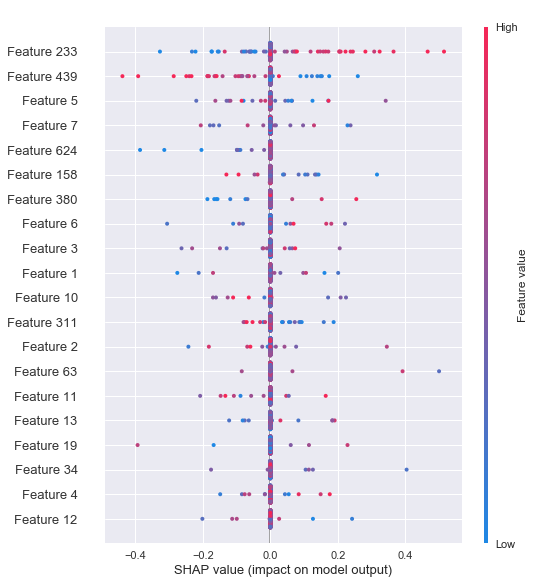

In [132]:
shap.summary_plot(shap_values_nb, X_train[0:275], max_display=20)

In [128]:
# Compute SHAP values for Naive Bayes - 500 samples
f_nb = lambda x: nb.predict_proba(x)[:,1]
med = np.median(X_train, axis=0).reshape((1,X_train.shape[1]))
explainer_nb = shap.KernelExplainer(f_nb, med)
shap_values_nb = explainer_nb.shap_values(X_train[0:275], nsamples=500)

100%|███████████████████████████████████████████████████████████████████████████████████| 275/275 [09:18<00:00,  2.03s/it]


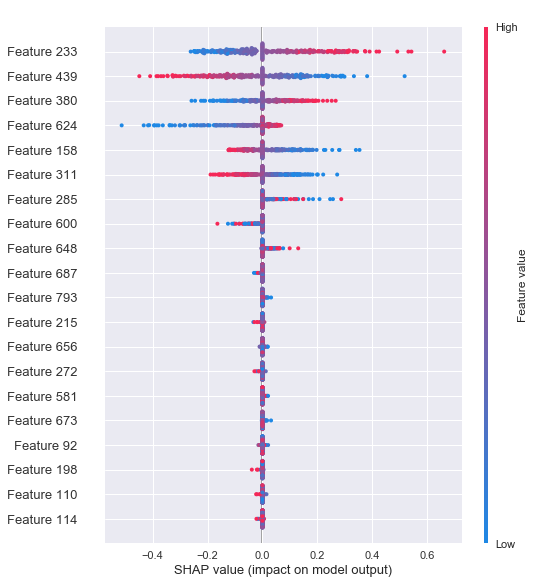

In [129]:
shap.summary_plot(shap_values_nb, X_train[0:275], max_display=20)

As we see, although using less samples to compute the SHAP values is faster, doesn't provide reliable explanations